<a href="https://colab.research.google.com/github/kiwi-0424/kiwi-0424/blob/Da-Rae/%EA%B3%BC%EC%A0%9C3_seq2seq(sequence_to_sequence)_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [밑바닥부터 시작하는 딥러닝2]
## 7장 RNN을 사용한 문장 생성

In [1]:
# If You use in Colab, You Should run this script
import os
if (not os.path.exists("./deep-learning-from-scratch-2") and
    not "deep-learning-from-scratch-2" in os.getcwd()):
    !git clone  https://github.com/WegraLee/deep-learning-from-scratch-2.git
    os.chdir("./deep-learning-from-scratch-2")
# !pip install wget

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 598, done.
remote: Total 598 (delta 0), reused 0 (delta 0), pack-reused 598
Receiving objects: 100% (598/598), 29.81 MiB | 33.47 MiB/s, done.
Resolving deltas: 100% (360/360), done.


In [16]:
# RNN 두 개를 연결하는 간단한(?) 방법으로 seq2seq 구현해보기

##7.1 언어모델을 사용한 문장 생성

##### [새로운 문장 생성 방법]
 + 1) (결정적인 방법) 즉 결과가 예측가능한 것으로서 다음 단어 선택할 때, 확률이 가장 높은 단어 선택하는 것 => 결과가 일정함
 + 2) (확률적인 방법) 결과가 확률에 따라 단어 선택, 두번째 단어는 첫번째에 선택한 단어를 모델에 입력해서 다음 단어의 확률분포를 얻어서 샘플링! => 단어가 매번 바뀜 (ex: beam search..)


+ Rnnlm 클래스를 상속한 RnnlmGen 클래스 작성
+ 각각의 Model의 Input Data에 대한 Forward를 Sample_size만큼 수행 함
+ 이후, 각 단어에 대한 결과값을 확률적으로 np.random.choice로서 고르는 식으로 수행

In [17]:
#[RnnlmGen 클래스의 구현]
#Rnnlm 클래스를 상속해서 RnnlmGen 클래스 만들고나서, 이 클래스에 문장 생성 메서드 추가하기

import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm): #Rnnlm 클래스 상속
    def generate(self, start_id, skip_ids=None, sample_size=100): 
    #generate(): 먼저 model.predict(x)를 호출해 각 단어의 점수 출력(정규화 전의 점수)
    #start_id: 최초로 주는 단어의 ID
    #skip_id: 샘플링 되지 않도록 하는 단어의 ID (<unk>, N 등) -<unk>: 단어의 수가 적은 단어, 전처리된 단어 등
    #sample_size: 샘플링 하는 단어의 수
        word_ids = [start_id] 

        x = start_id
        while len(word_ids) < sample_size: #내가원하는 단어길이를 벗어나면 stop
            x = np.array(x).reshape(1, 1)
            score = self.predict(x) #각 단어의 점수, 미니배치를 지원함. 그래서 x는 2차원 배열인것!
                                    #단어ID를 하나만 입력해도 1로 미니배치크기를 지정해서 reshape(1,1)을 한다고 함
            p = softmax(score.flatten()) #p= softmax(score) 코드에서는 점수들을 소프트맥스 함수를 이용해 정규화
        

            sampled = np.random.choice(len(p), size=1, p=p)
              #목표로 하는 확률분포 p 얻고 난 후, 확률분포 p로 단어 샘플링해서 x에 줌
            if (skip_ids is None) or (sampled not in skip_ids): 
                x = sampled
                word_ids.append(int(x)) #int니까 단어의 index가 들어옴
              #샘플링 금지 단어가 없거나 샘플링한 단어가 샘플링 금지 단어 리스트 안에 없다면 -> word_ids에 추가

        return word_ids
              #word_ids 반환

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c #LSTM에서 따로 가져옴

    def set_state(self, state):
        self.lstm_layer.set_state(*state)


        #< eos>: 문장의 끝을 알려주는 Tag

In [18]:
# (1) self.predict(x)를 통해 정규화 되기 전 각 단어의 점수 호출
# (2) p = softmax(socre.flatten())을 통해 이 점수들을 소프트맥스 함수를 통해 정규화 >> 목표로 하는 확률분포 얻는다.
# (3) sampled = np.random.choice(len(p), size=1, p=p)를 통해 다음 단어 샘플링(랜덤으로 초이스)
# (4) 샘플링 금지 단어가 없거나 샘플링한 단어가 샘플링 금지 단어 리스트 안에 없다면 -> word_ids에 추가
# (5) word_ids 반환

In [19]:
#[RnnlmGen에서 발전시켜서 BetterRnnlmGen 구현해보기]
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

#LSTM의 아키텍쳐가 다름
    def get_state(self):
        states = []
        for layer in self.lstm_layers:  #레이어의 갯수가 다층이라 list 관리를 함
            states.append((layer.h, layer.c)) #튜플로 저장
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)
            

In [20]:
# 문장생성(ch07/generate_text.py)

import sys
sys.path.append('..')
#from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

# 말뭉치 +  모델 불러오기
model = RnnlmGen()
model.load_params('../ch06/Rnnlm.pkl')

# start(시작) 문자와 skip(스킵) 문자 설정
start_word = 'you'  #시작 단어 설정 = "you"
start_id = word_to_id[start_word] #시작 단어를 단어 ID로 변환
skip_words = ['N', '<unk>', '$'] #skip_words설정(unk=unknown 샘플링하면 안 되는 단어 리스트)
skip_ids = [word_to_id[w] for w in skip_words] #skip_words를 단어 ID로 변환

# 문장 생성
word_ids = model.generate(start_id, skip_ids) #모델 동작 (단어ID로 이루어진 리스트로 반환)
txt = ' '.join([id_to_word[i] for i in word_ids]) #txt변수에 .join()메소드를 이용해 띄어쓰기 구분자를 활용해 단어 ID(숫자) -> 단어(문자열)로 변환
txt = txt.replace(' <eos>', '.\n') #문장 끝에 있는 구분 단어인 '<eos>' = end of sentences 를 줄바꿈을 의미하는 '.\n'로 변환
print(txt)


you add.
 mr. roman predicted subsequently on the next couple relationship is causing competition from the campaign 's open on almost two-thirds of power requirements.
 saturday night with mr. freeman who had made an internal firm to extend its core of corn and connecticut to the opposite.
 but the coast of the nation 's biggest specific political expert at the mercantile conference may have the in a previously advisory supply of the company says.
 the robot copy of college could receive homes for the month.
 it has had been executed 's concentrating on the senior


In [21]:
#1) 말뭉치 불러오기
#2) 모델 불러오기
#3) 시작 단어 "you" 설정
#4) 시작 단어를 단어 ID로 변환
#5) skip_words설정(샘플링하면 안 되는 단어 리스트)
#6) skip_words를 단어 ID로 변환
#7) 모델 동작 (단어ID로 이루어진 리스트로 반환)
#8) txt변수에 .join()메소드를 이용해 띄어쓰기 구분자를 활용해 단어 ID(숫자) -> 단어(문자열)로 변환
#9) 문장 끝에 있는 구분 단어인 ' <eos>'를 줄바꿈을 의미하는 '.\n'로 변환

##7.2. seq2seq(sequence to sequence)
  + 입력 sequence와 출력 sequence간의 함수관계를 학습하는 모형
  + seq2seq는 from seq to seq 를 뜻하는 말로, 하나의 시계열 데이터를 다른 시계열 데이터로 변환하는 것을 의미함
  + Encoder-Decoder 모델이라고도 하는데, seq2seq의 Encoder는 입력 데이터를 인코딩(부호화)하고, Decoder는 인코딩된 데이터를 디코딩(복호화)하여 사용하기 때문임
  + 인코딩:정보를 어떤 규칙에 따라 변환 ↔ 디코딩: 인코딩된 정보를 원래의 정보로 되돌리는 변환

  + Encoder의 LSTM 하나와 Decoder의 LSTM 하나로 총 2개의 LSTM으로 이루어져 있음
  + 중간에 은닉 벡터 h를 통해 순전파때는 코딩된 정보가 Decoder로 넘어가고, 역전파때는 기울기가 Encoder로 넘어감
  + Encoder, Decoder LSTM으로 구성(hidden state를 통해 기울기 전달)
  + 기계번역, 챗봇, 음성인식, 메일의 자동 답신 등의 문제에 응용 

####[사계열 데이터 변환용 장난감 문제]
##### 57+5 와 같은 문자열을 seq2seq에 건네면 62라는 정답을 내놓도록 학습시키기
※이처럼 머신러닝을 평가하고자 만든 간단한 문제를 '장난감 문제(tory problem)'이라고 함


  + 1) 그동안은 word2vec이나 언어 모델등에서 문장을 '단어'단위로 분할했으나, 여기서는 '문자'단위로 분할 ex) 57+5 가 입력되면 ['5','7','+','5']라는 리스트로 처리하는 것
  + 2) 샘플마다 데이터의 시간 방향 크기가 다르기 때문에 즉 가변길이 시계열 데이터를 다루는 것임. 신경망학습시 '미니배치 처리'를 하려면 추가노력이 필요함
  + 3) 미니배치에 속한 샘플들의 데이터 형상이 모두 같아야 하기 때문에 패딩(padding)을 이용함. 패딩은 원래의 데이터에 의미없는 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 기법임. (모든 입력 데이터의 길이를 통일하고, 남는 공간에는 의미없는 데이터로 채우기)


In [22]:
#[장난감문제] : ch07/show_addition_dataset.py
import sys
sys.path.append('..')
from dataset import sequence  #sequence모듈을 이용해서 seq2seq용데이터 읽어들이기

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984) 
    #load_data(file_name, seed)는 file_name으로 지정한 텍스트 파일을 읽어 텍스트를 문자ID로 변환하고, 훈련데이터와 테스트 세트로 나누어 변환
    #seed는 이 메서드 내부에서 사용하는 무작위수의 초기값
char_to_id, id_to_char = sequence.get_vocab() #get_vocab()메서드는 문자와 문자ID의 대응 관계를 담은 딕셔너리를 반환함 (실제로는 char_to_id와 id_to_char이라는 2개의 딕셔너리를 돌려줌)

print(x_train.shape, t_train.shape)  #훈련용데이터로는 학습을 함
print(x_test.shape, t_test.shape) #테스트용데이터로는 모델의 성능을 평가함
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


##7.3. seq2seq(sequence to sequence) 구현

### 1) Encoder 클래스  
+ Encoder 클래스는 문자열을 받아 벡터 h로 변환
+ RNN을 이용, 시계열 데이터(임의 길이)를 hidden state vector(고정 길이) 로 변환

+ 마지막 hidden state(h) 에 입력된 문장 번역시 필요한 정보 인코딩
+ "< eos > 라는 구분자를 이용해서 Decoder에 문장생성의 시작과 끝을 알리는 신호로 사용함. 다른문헌에서는 < go>, < start> 밑줄_ 등을 이용하기도 함

In [23]:
# Encoder 클래스 코드
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size): #초기화 메서드
      #vocab_size: 어휘수 (문장의 종류) 
      ##(책에서는 0~9의 숫자와 '+', ''(공백), '_'을 합쳐 총 13가지 문자 사용)
      #wordvec_size: 문자 벡터의 차원 수
      #hidden_size: LSTM 계층의 은닉 상태 벡터의 차원 수
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params #params: 가중치 매개변수
        self.grads = self.embed.grads + self.lstm.grads #grads: 기울기
        self.hs = None  #hs: Decoder에 첫번째 입력 상태의 값으로 사용할 Context Vector

#ch07/seqseq.py     
    def forward(self, xs): #순전파 메서드
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    #Time Embedding 계층과 Time LSTM 계층의forward() 메서드를 호출
    ##Time LSTM 계층의 마지막 시각의 은닉 상태만을 추출해, 그 값을 출력으로 반환

    def backward(self, dh): #역전파 메서드  #dh:LSTM 계층의 마지막 은닉상태에 대한 기울기(디코더가 전해주는 기울기)
        dhs = np.zeros_like(self.hs) #dhs(역전파시) - 원소가 모두 0인 텐서
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout
    #LSTM 계층의 마지막 은닉 상태에 대한 기울기가 dh 인수로 전해짐. 
    ##(Decoder가 전해주는 기울기) , 
    ###np.zeros_like를 통해 원소가 모두 0인 텐서dhs를 생성 -> dh를 dhs의 해당위치에 할당
    ####마지막으로 Time LSTM 계층과 Time Embedding 계층의 backward() 메서드 호출

### 2) Decoder 클래스
+ Decoder 클래스는 Encoder 클래스가 출력한 h를 받아 목적으로 하는 다른 문자열을 출력
+ 기존 신경망 구성LSTM 계층이 vector h 를 입력받음

In [24]:
# Decoder 클래스 코드  #ch07/seq2seq.py
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')  #numpy에서 float를 f라고 약어로 쓰기도함
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')   #  np.sqrt(): numpy 배열의 제곱근을 계산
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        #짧은 시계열 여러개를 입력받기 때문에 은닉상태 초기화g한 상태로 지정(영벡터) stateful
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore): #위쪽의 Softmax with Loss계층으로부터 기울이 dscore를 받아 Time Affine -> Time LSTM -> Time Embedding 계층에 전파함
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh #이 시간 방향의 기울기 dh를 꺼내서 Decoder클래스의 backward()의 출력으로 반환함
        return dh
    
    # Decoder 클래스에 문장 생성을 담당하는 generte() 메서드
    def generate(self, h, start_id, sample_size): 
      #h: Encoder로부터 받는 은닉상태
      #start_id: 최초로 주어지는 문자 ID
      #sample_size: 생성하는 문자 수
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())  #argmax노드는 최대값을 가진 원소의 인덱스(이번 예에서는 문자ID)를 선택하는 노드임
            sampled.append(int(sample_id))

        return sampled

### 3) Seq2seq 클래스
+ Seq2seq 클래스는 Encoder 클래스와 Decoder 클래스를 ★연결하고, Time Softmax with Loss 계층을 이용해 손실을 계산

In [25]:
# Seq2seq 클래스 코드  #ch07/seq2seq.py
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

### 4) Seq2seq 실행해보기
+ 학습데이터에서 미니배치 선택 - 미니배치로부터 기울기 계산 - 기울기를 사용하여 매개변수 update
+ 매 에폭마다 seq2seq가 테스트 데이터를 풀게하여=문자열 생성을 수행하여, 학습 중간중간 정답률 측정!

In [2]:
os.chdir("./ch07")

In [4]:
os.getcwd

<function posix.getcwd>

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 7[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 12[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 13[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 17[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 18[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 19[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 20[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

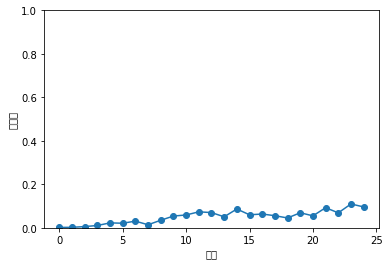

In [9]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()


# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델/옵티마이저/트레이너생성 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose)
        #eval_seq2seq 메서드는 인수를 6개 받음
        #모델을 뜻하는 model, 문제문장(문장ID의 배열)인 question, 정답(문자ID의 배열)인 correct
        #id_to_char은 문자 ID와 문자 변환을 수행하는 딕셔너리
        #verbose는 결과를 출력할지 여부
        #is_reverse는 입력문을 반전했는지 여부 
        #verbose=True로 설정하면 결과를 터미널로 출력함

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))


# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()    


### 5) Seq2seq 개선해보기
#### seq2seq를 세분화하여 학습 '속도'를 개선하기 위한 두가지 방법
+ 입력 데이터 반전(Reverse)


| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 7[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 11[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 12[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 13[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 16[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 17[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 18[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 19[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 21[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1001
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1001
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

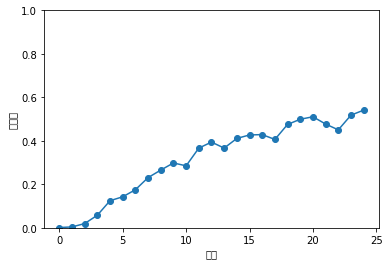

In [13]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()